В данном ноутбуке на основе получившейся в режиме разработки ML-модели проводится обработка тествых HMI и SSTS-виз, определение для них комплаенс-меток и формирование отчета в виде `sumbission.csv`.

Структура:

1. Imports
- Импорт функциональной и бизнес логики из Python-библиотек и модулей src/modules
2. Config
- Преднастройка основных сущностей и правил, используемых в ноутбуке
3. Data Loading
- Формирование датасета без целевого признака в соответсвии со следующими полями:
    - id - идентификатор кейса, по которому формируются заключения HMI и SSTS
    - case_name - название кейса
    - full_uc_text - текст визы HMI
    - full_ssts_text - текст визы SSTS
    - main_scenario - текст из под заголовка визы HMI
    - postconditions - текст из под заголовка визы HMI
    - other - текст из прочих заголовков визы HMI
    - preconditions - текст из под заголовка визы HMI
    - goal - текст из под заголовка визы HMI
    - differences - слова и их количество, присутствующие в HMI, но отсутсвующие в SSTS
    - description - слова и их количество, присутствующие в SSTS, но отсутсвующие в HMI
3. Models Loading
- Происходит инициализация модели BERT и Токинайзера
- Происходит загрузка полученной из режима разработки ML-модели
- Для каждого кейса предсказывается комплаенс-метка с помощью жесткой логики и ML-модели
4. Report Creation
- Формируется отчет `submission.csv` со следующей структурой:
    - Number - id кейса
    - Name - название кейса
    - Differences - слова и их количество, присутствующие в SSTS, но отсутсвующие в HMI
    - Description - слова и их количество, присутствующие в SSTS, но отсутсвующие в HMI
    - Complience Level - опредленная на основе предсказания ML-модели комплаенс-метрика

# Imports

In [1]:
from pathlib import Path
import sys
from datetime import datetime
import logging
import warnings
import time

abs_path = Path().resolve()
sys.path.append(str(abs_path / "src" / "modules"))

from sklearn.linear_model import LinearRegression
import plotly.express as px

import ascii_atom
from files_funcs import *
from docx_funcs import *
from nlp_funcs import *
from ml_funcs import *
from timer_func import *
from eda_funcs import *


warnings.filterwarnings("ignore")

log_dir = abs_path / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
log_file = log_dir / f'{datetime.now().strftime("%Y-%m-%d")}.log'

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler(log_file, mode='a', encoding='utf-8')
    ]
)

logger = logging.getLogger(__name__)

logger.info(ascii_atom.start)
logger.info(ascii_atom.cred)
logger.info("Inference started successfully.")

start_ = time.time()
logger.info("Timer started.\n")

c:\Users\yytrb\OneDrive\Рабочий стол\atom-compliance-ml\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-10 10:30:16,133 - __main__ - INFO - 

  /$$$$$$                                    /$$ /$$                                               /$$      /$$ /$$             /$$$$$$$                                               /$$          
 /$$__  $$                                  | $$|__/                                              | $$$    /$$$| $$            | $$__  $$                                             | $$          
| $$  \__/  /$$$$$$  /$$$$$$/$$$$   /$$$$$$ | $$ /$$  /$$$$$$  /$$$$$$$   /$$$$$$$  /$$$$$$       | $$$$  /$$$$| $$            | $$  \ $$ /$$$$$$   /$$$$$$  /$$  /$$$$$$   /$$$$$$$ /$$$$$$        
| $$       /$$__  $$| $$_  $$_  $$ /$$__  $$| $$| $$ |____  $$| $$__  $$ /$$__

# Config

In [2]:
main_dir = abs_path

config_path = main_dir / "config" / "config.yaml"
config = load_yaml(config_path)

data_dir = abs_path / "data"
uc_data_dir = data_dir / "test_data" / "HMI"
ssts_data_dir = data_dir / "test_data" / "SSTS"

model_dir = main_dir / "models"

columns = (
        config["ds_topology"]["main_columns"]
        + list(set(config["ds_topology"]["hmi_subheaders"].values()))
        + config["ds_topology"]["targets"]
)
columns = [col.lower().replace(" ", "_") for col in columns]

text_cols = [f'{col}' for col in set(config["ds_topology"]["hmi_subheaders"].values())]
text_cols = text_cols + ["differences"]
text_cols = ["differences", "postconditions", "preconditions"]

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logger.info(f'Device: {DEVICE}')

2024-11-10 10:30:16,155 - __main__ - INFO - Device: cpu


# Data Loading

In [3]:
ds = create_ds(uc_data_dir, ssts_data_dir, columns)
logger.info("Data loaded.")

ds

2024-11-10 10:30:16,682 - __main__ - INFO - Data loaded.


,id,case_name,full_uc_text,full_ssts_text,goal,preconditions,other,postconditions,main_scenario,differences,description,complience_level
0,259572,Mute/unmute the FM Radio playback,[I-25957] Mute/unmute the FM Radio playback\nD...,Mute or pause function\nFunctional Description...,"Goal: ""Users are able to mute/unmute the FM Ra...",Preconditions:\nUser is playing FM Radio,Description:,Postconditions:\nThe user Mutes/Unmutes the FM...,Main Scenario:\n​​​User clicks on soft button ...,Next words are missing in UC-text:\n- [I-25957...,Next words are missing in SSTS-text:\n Mute: 1...,None
1,65831,Driver initiate a call through SWP,[I-6583] Driver initiate a call through SWP\n...,Make a call (B sample)\nFunctional Description...,,Preconditions:\nThe IVI is on in_2 \nThe vehic...,,Postconditions:\nIf the call is initiated succ...,Main Scenario:\nThe driver navigates to the 'C...,Next words are missing in UC-text:\n- [I-6583]...,Next words are missing in SSTS-text:\n Make: 4...,None
2,30364,Stop charging when the cut-off SOC is reached,[I-30364] Stop charging when the cut-off SOC ...,Maximum charging SOC value setting\nFunctional...,Goal: To notify and display the user that the ...,,"Description: Scope: SWP, Mobile App, SoundActo...",,,Next words are missing in UC-text:\n- [I-30364...,Next words are missing in SSTS-text:\n Maximum...,None
3,86921,Emergency Service Communication (ERA-Glonass),[I-8692] Emergency Service Communication (ERA...,Manual dialing E-CALL\nFunctional Description\n\n,,Preconditions:\nThe vehicle is in the Drive St...,Trigger:\nThe vehicle sensors detect a collisi...,Postconditions：\nThe driver is able to communi...,Main Scenario:\nThe ERA-Glonass initiates emer...,Next words are missing in UC-text:\n- [I-8692]...,Next words are missing in SSTS-text:\n Manual:...,None
4,315231,Adding Internet Radio to Favorites List,[I-31523] Adding Internet Radio to Favorites ...,Favorite Song operation\nFunctional Descriptio...,Goal: User wants to add favorites internet rad...,Preconditions:\nUser in in the Internet Radio ...,Description: Actors:\nCar User \nIVI Triggers:...,Postconditions:\nThe selected internet radio s...,Main Scenario:\nThe user press on the UI inter...,Next words are missing in UC-text:\n- [I-31523...,Next words are missing in SSTS-text:\n Favorit...,None
5,30365,Start the Charging Process via Soft Switch,[I-30365] Start the Charging Process via Soft...,Functional Description\nUsers can choose the s...,Goal: the driver can navigate to the charging ...,Preconditions: \nThe vehicle is in Parking mod...,"Description: \nScope: SWP, Mobile AppActors: d...",,Main Scenario:\nThe user navigates to the char...,Next words are missing in UC-text:\n- [I-30365...,Next words are missing in SSTS-text:\n Functio...,None
6,88002,Receiving Call Notifications,[I-8800] Receiving Call Notifications\nPrecon...,Receiving Call Notifications\nFunctional Descr...,,Preconditions\nEntertainment system is ready. ...,,"Postconditions:\nIf the call is accepted, the ...",Main Scenario:\nAn incoming call is received o...,Next words are missing in UC-text:\n- [I-8800]...,Next words are missing in SSTS-text:\n Functio...,None
7,29448,Configure heat preservation,[I-29448] Configure heat preservation\nDescri...,Functional Description\nusers can set the batt...,Goal: configure heat preservation,,Description: Scope: user turn on/ off heat pre...,,,Next words are missing in UC-text:\n- [I-29448...,Next words are missing in SSTS-text:\n Functio...,None
8,30370,Stop the discharging process (Updated),[I-30370] Stop the discharging process (Updat...,Functional Description\nThe user can select th...,,,Description: Triggers:\nThe vehicle is not in ...,,Main Scenario:\nThe discharge process stops \n...,Next words are missing in UC-text:\n- [I-30370...,Next words are missing in SSTS-text:\n Functio...,None
9,65833,Driver initiate a call through SWP,[I-6583] Driver initiate a call through SWP\n...,Make a call (B sample)\nFunctional Description...,,Precond

# Models Loading

## BERT

In [4]:
bert_model = (
    BertModel
    .from_pretrained(config["bert"], output_hidden_states=True)
    .to(DEVICE)
)
tokenizer = BertTokenizer.from_pretrained(config["bert"])

logger.info(bert_model)
logger.info(tokenizer)

2024-11-10 10:30:20,684 - __main__ - INFO - BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       

## Developed ML Model

In [5]:
model_path = model_dir / create_model_name(LinearRegression())

model = pickle_to_obj(model_path)

logger.info(f'Developed ML Model loaded: {model}')
model

2024-11-10 10:30:20,700 - __main__ - INFO - Developed ML Model loaded: LinearRegression()


LinearRegression()

# Proccessing & prediction

In [6]:
ssts_texts = pd.DataFrame(ds["full_ssts_text"]).fillna("EMPTY")
ssts_texts_vectorized = extract_text_vectors(
    ssts_texts,
    "full_ssts_text",
    bert_model,
    tokenizer,
    DEVICE,
    verbose=False
).drop("full_ssts_text", axis=1)

for col in text_cols:
    ds[f'f_{col}'] = get_pairwise_dist_with_ssts(
        ds[col],
        ssts_texts_vectorized,
        config["distance_metric"],
        bert_model=bert_model,
        tokenizer=tokenizer,
        device=DEVICE,
        verbose=False
    )

logger.info("Dataset processed.")
ds

2024-11-10 10:30:32,321 - __main__ - INFO - Dataset processed.


,id,case_name,full_uc_text,full_ssts_text,goal,preconditions,other,postconditions,main_scenario,differences,description,complience_level,f_differences,f_postconditions,f_preconditions
0,259572,Mute/unmute the FM Radio playback,[I-25957] Mute/unmute the FM Radio playback\nD...,Mute or pause function\nFunctional Description...,"Goal: ""Users are able to mute/unmute the FM Ra...",Preconditions:\nUser is playing FM Radio,Description:,Postconditions:\nThe user Mutes/Unmutes the FM...,Main Scenario:\n​​​User clicks on soft button ...,Next words are missing in UC-text:\n- [I-25957...,Next words are missing in SSTS-text:\n Mute: 1...,None,0.236538,0.230639,0.294097
1,65831,Driver initiate a call through SWP,[I-6583] Driver initiate a call through SWP\n...,Make a call (B sample)\nFunctional Description...,,Preconditions:\nThe IVI is on in_2 \nThe vehic...,,Postconditions:\nIf the call is initiated succ...,Main Scenario:\nThe driver navigates to the 'C...,Next words are missing in UC-text:\n- [I-6583]...,Next words are missing in SSTS-text:\n Make: 4...,None,0.210658,0.142870,0.114146
2,30364,Stop charging when the cut-off SOC is reached,[I-30364] Stop charging when the cut-off SOC ...,Maximum charging SOC value setting\nFunctional...,Goal: To notify and display the user that the ...,,"Description: Scope: SWP, Mobile App, SoundActo...",,,Next words are missing in UC-text:\n- [I-30364...,Next words are missing in SSTS-text:\n Maximum...,None,0.229322,0.739345,0.739345
3,86921,Emergency Service Communication (ERA-Glonass),[I-8692] Emergency Service Communication (ERA...,Manual dialing E-CALL\nFunctional Description\n\n,,Preconditions:\nThe vehicle is in the Drive St...,Trigger:\nThe vehicle sensors detect a collisi...,Postconditions：\nThe driver is able to communi...,Main Scenario:\nThe ERA-Glonass initiates emer...,Next words are missing in UC-text:\n- [I-8692]...,Next words are missing in SSTS-text:\n Manual:...,None,0.415040,0.309565,0.368632
4,315231,Adding Internet Radio to Favorites List,[I-31523] Adding Internet Radio to Favorites ...,Favorite Song operation\nFunctional Descriptio...,Goal: User wants to add favorites internet rad...,Preconditions:\nUser in in the Internet Radio ...,Description: Actors:\nCar User \nIVI Triggers:...,Postconditions:\nThe selected internet radio s...,Main Scenario:\nThe user press on the UI inter...,Next words are missing in UC-text:\n- [I-31523...,Next words are missing in SSTS-text:\n Favorit...,None,0.224307,0.322608,0.356404
5,30365,Start the Charging Process via Soft Switch,[I-30365] Start the Charging Process via Soft...,Functional Description\nUsers can choose the s...,Goal: the driver can navigate to the charging ...,Preconditions: \nThe vehicle is in Parking mod...,"Description: \nScope: SWP, Mobile AppActors: d...",,Main Scenario:\nThe user navigates to the char...,Next words are missing in UC-text:\n- [I-30365...,Next words are missing in SSTS-text:\n Functio...,None,0.233443,0.779060,0.247179
6,88002,Receiving Call Notifications,[I-8800] Receiving Call Notifications\nPrecon...,Receiving Call Notifications\nFunctional Descr...,,Preconditions\nEntertainment system is ready. ...,,"Postconditions:\nIf the call is accepted, the ...",Main Scenario:\nAn incoming call is received o...,Next words are missing in UC-text:\n- [I-8800]...,Next words are missing in SSTS-text:\n Functio...,None,0.232214,0.105264,0.193543
7,29448,Configure heat preservation,[I-29448] Configure heat preservation\nDescri...,Functional Description\nusers can set the batt...,Goal: configure heat preservation,,Description: Scope: user turn on/ off heat pre...,,,Next words are missing in UC-text:\n- [I-29448...,Next words are missing in SSTS-text:\n Functio...,None,0.227693,0.776996,0.776996
8,30370,Stop the discharging process (Updated),[I-30370] Stop the discharging process (Updat...,Functional Description\nThe user can select th...,,,Description: Triggers:\nThe vehicle is not in ...,,Main Scenario:\nThe discharge process stop

In [7]:
X = ds[sorted([f for f in ds.columns if f.startswith(("f_"))])]

kickouts_indexes = get_kickouts_indexes(ds)
logger.info(f'Kickouts indexes: {kickouts_indexes}')

preds = np.clip(model.predict(X), 2, 5)
preds[kickouts_indexes] = 1
logger.info(f'Predictions: {preds}')

preds

2024-11-10 10:30:32,342 - __main__ - INFO - Kickouts indexes: Index([], dtype='int64')
2024-11-10 10:30:32,344 - __main__ - INFO - Predictions: [3.99669273 2.67098919 4.09354202 3.02728565 3.81966331 2.
 4.13971507 4.17410327 3.99741742 2.93744852 3.96135562 4.50592589
 3.24682521 2.79912861 4.34356395]


array([3.99669273, 2.67098919, 4.09354202, 3.02728565, 3.81966331,
       2.        , 4.13971507, 4.17410327, 3.99741742, 2.93744852,
       3.96135562, 4.50592589, 3.24682521, 2.79912861, 4.34356395])

# Report Creation

2024-11-10 10:30:32,356 - __main__ - INFO - Complience Level
LC    8
PC    5
NC    1
FC    1
Name: count, dtype: int64


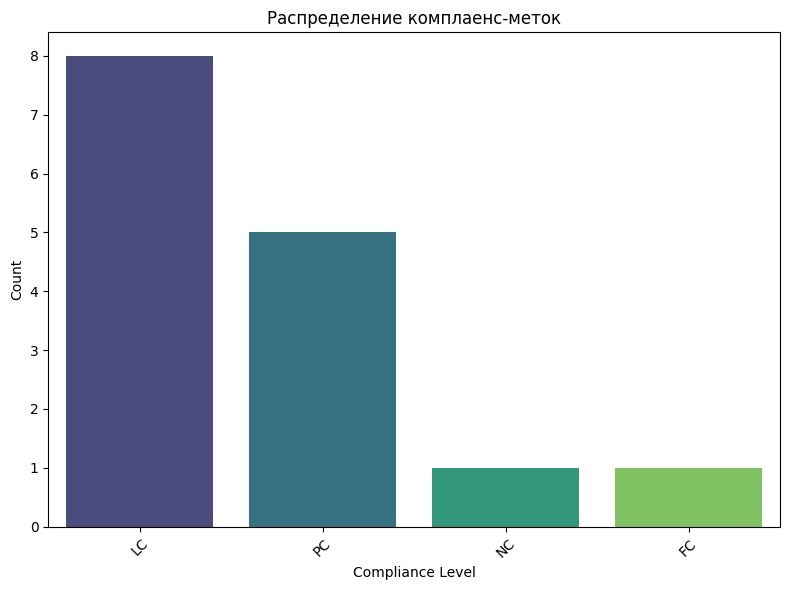

,Number,Name,Differences,Description,Complience Level
0,259572,Mute/unmute the FM Radio playback,Next words are missing in UC-text:\n- [I-25957...,Next words are missing in SSTS-text:\n Mute: 1...,LC
1,65831,Driver initiate a call through SWP,Next words are missing in UC-text:\n- [I-6583]...,Next words are missing in SSTS-text:\n Make: 4...,PC
2,30364,Stop charging when the cut-off SOC is reached,Next words are missing in UC-text:\n- [I-30364...,Next words are missing in SSTS-text:\n Maximum...,LC
3,86921,Emergency Service Communication (ERA-Glonass),Next words are missing in UC-text:\n- [I-8692]...,Next words are missing in SSTS-text:\n Manual:...,PC
4,315231,Adding Internet Radio to Favorites List,Next words are missing in UC-text:\n- [I-31523...,Next words are missing in SSTS-text:\n Favorit...,LC
5,30365,Start the Charging Process via Soft Switch,Next words are missing in UC-text:\n- [I-30365...,Next words are missing in SSTS-text:\n Functio...,NC
6,88002,Receiving Call Notifications,Next words are missing in UC-text:\n- [I-8800]...,Next words are missing in SSTS-text:\n Functio...,LC
7,29448,Configure heat preservation,Next words are missing in UC-text:\n- [I-29448...,Next words are missing in SSTS-text:\n Functio...,LC
8,30370,Stop the discharging process (Updated),Next words are missing in UC-text:\n- [I-30370...,Next words are missing in SSTS-text:\n Functio...,LC
9,65833,Driver initiate a call through SWP,Next words are missing in UC-text:\n- [I-6583]...,Next words are missing in SSTS-text:\n Make: 2...,PC


In [8]:
report = ds[config["report_columns"]]
report["complience_level"] = preds
report["complience_level"] = (
    round(report["complience_level"])
    .astype("int16")
    .map(
        {v: k for k, v in config["target_dict"].items()}
    )
)
report = report.rename(
    columns={
        "id": "Number",
        "case_name": "Name",
        "differences": "Differences",
        "description": "Description",
        "complience_level": "Complience Level"
    }
)

logger.info(report["Complience Level"].value_counts())

report_dir = abs_path / "submissions"

report.to_csv(report_dir / "submission.csv", index=False)
plot_compliance_distribution(report, True, report_dir)
report

In [9]:
timer_val = exec_time(start_, time.time())

logger.info(f'Inference fineshed. Executed time: {timer_val}')
timer_val

2024-11-10 10:30:32,617 - __main__ - INFO - Inference fineshed. Executed time: Completed for 00:00:16


'Completed for 00:00:16'